# Automatic geological modelling

This notebook uses map2loop to deconstruct a geological map into an input dataset for LoopStructural. The notebook is intended to be run as a part of the subsurface transform 21 workshop by Lachlan Grose and Mark Jessell. This notebook uses data provided by the Geological Survey of Western Australia ([license](licenses/gswalicence.pdf)).

Using this notebook you will:
* deconstruct a geological map using map2loop and augment the dataset for input into LoopStructural
* understand how the dataset is interpreted by LoopStructural
* build a geological model using LoopStructural
* visualise the geological model using lavavu


If you want to try and use map2loop with your own data there is a guide [here](map2loop_extras/Using%20map2loop%20with%20your%20own%20data.ipynb), however map2loop is still under development and may require some modification to the dataset/process to work with your data. 

In [3]:
import folium
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import numpy as np
from shapely.geometry import Polygon, shape
import geopandas
from shapely.geometry import shape 
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer


## Interactive map selector for Western Australia
Using the following interactive map select an area to build a model of or use the preselected area to build a model. Please note that the larger the area of the model does increase the computational time so select an area that is a similar size to the area we have provided. 

In [4]:
map_crs = 'EPSG:4326'
proj_crs = 'EPSG:28350'

In [5]:
center=(-22.6,117.3)


wms_warox = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:waroxi_wa_4326_bed',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSWA',
    name='outcrops'

)
wms_geol = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:2_5m_interpgeop15_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSWA',
    name='geology'

)
m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=8,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_warox)
# if(not test_data_name =='Draw Your Own'):
#     m.add_layer(example_rect)

### PREDEFINED AREA
existing_extent = (116.97971, -22.369087, 117.891692, -22.95456)
center = (existing_extent[1]+existing_extent[3])/2, (existing_extent[0]+existing_extent[2])/2
minlat = existing_extent[3]
maxlat = existing_extent[1]
minlong = existing_extent[2]
maxlong = existing_extent[0]
lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = geopandas.GeoDataFrame(index=[0], crs=map_crs, geometry=[bbox_geom])
example_rect = GeoData(geo_dataframe = mbbox,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
mbbox=mbbox.to_crs(proj_crs)
m.add_layer(example_rect)


## END PREDEFINED AREA
m.add_control(LayersControl())
dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
m.add_control(dc)
m

Label(value='')

Map(center=[-22.6, 117.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [6]:
draw = dc.last_draw
try:
    poly = shape(draw['geometry'])
    poly_gdf = geopandas.GeoDataFrame([1], geometry=[poly], crs=map_crs)
    bbox_gdf = poly_gdf.to_crs(proj_crs)
    bbox_3d = {"minx": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "miny": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "maxx": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "maxy": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "base": -3200,
         "top": 1200,}
except:
    minx = mbbox.total_bounds[0]
    maxx = mbbox.total_bounds[2]
    miny = mbbox.total_bounds[1]
    maxy = mbbox.total_bounds[3]# [ 274934.13200956 6297758.41393543  323980.90024616 6329307.64682912]
    bbox_3d = {'minx': minx,
     'miny': miny,
     'maxx': maxx,
     'maxy': maxy,
     'base': -3200,
     'top': 1200}

## Map2Loop
https://github.com/Loop3D/map2loop-2

The following cell runs map2loop using a remote dataset for Western Australia (currently sourced from the Loop GIS server). This sets the source files for the geology shapefiles, fault lines, orientation datasets and determines which attributes correspond to the relevant map2loop requirements. 


 orientations layer  metadata
--------------------
    bbox [ 497958.99865212 7461731.03443225  590940.86894353 7525734.9115111 ]
    CRS None
    # items 256
    Data types ['Point']

 geology layer  metadata
--------------------
    bbox [ 403072.24338592 7397753.5843496   680922.55097212 7540839.53920265]
    CRS None
    # items 149
    Data types ['MultiPolygon']

 fold layer  metadata
--------------------
    bbox [ 497911.11178574 7461232.9764797   591803.77840236 7526319.22227762]
    CRS None
    # items 16
    Data types ['LineString']
original no of faults: 95
geometry        LINESTRING (568748.86295698 7497204.91630132, ...
gml_id                                           linear_500k.6825
objectid                                                     6825
feature                                Fault or shear zone, major
type                                                      exposed
fname                                                        None
code                     


 mindeps layer  metadata
--------------------
    bbox [ 498334.95320903 7461336.51822418  588296.69699383 7526248.88674543]
    CRS None
    # items 222
    Data types ['Point']

 mindeps layer  metadata
--------------------
    bbox [ 498334.95320903 7461336.51822418  588296.69699383 7526248.88674543]
    CRS None
    # items 222
    Data types ['Point']

Warnings:
     149 NaN/blank found in column "supersuite" of geology file, replacing with 0
     No fault dip estimate text for fault polylines
     No fault name for fault polylines
     95 NaN/blank found in column "dip_dir" of fault file, replacing with -999
     95 NaN/blank found in column "dip_est" of fault file, replacing with -999
No gaps between geology polygons
No overlaps between geology polygons

No errors found, clipped and updated files saved to tmp
Ashburton_Formation #FEE2BD
Beasley_River_Quartzite #F1BC89
Boolgeeda_Iron_Formation #B5E1FC
Boongal_Formation #EEEFE2
Brockman_Iron_Formation #84CDFA
Bunjinah_Formation #

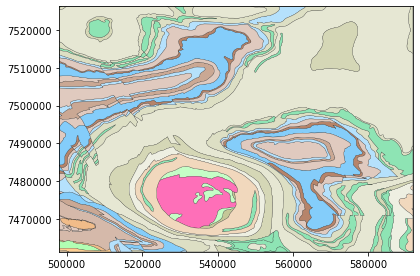

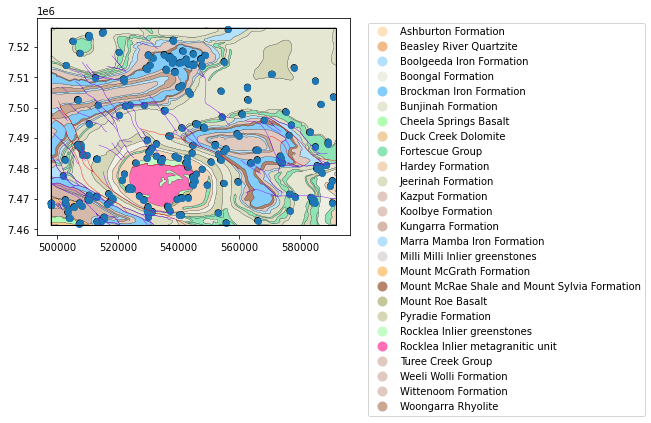

In [7]:
import os
import hjson
from map2loop.project import Project
%matplotlib inline
proj = Project( 
                 loopdata_state = "WA",)

proj.update_config(
                    out_dir='./test',
                    bbox_3d=bbox_3d,
                    proj_crs={'init': 'EPSG:28350'},
                    overwrite='true',
                  )

  0%|          | 0/100 [00:00<?, ?it/s]

Generating topology analyser input...
149  polygons
Successful parameter load
Output directory created at: ./test/graph
Topology analysis complete.

Resolving ambiguities using ASUD...	output_dir:Done.
Generating topology graph display and unit groups...
0    'Fortescue Group', 'anchor': 'n', 'fontStyle': 'bold'
1    'Hamersley Group', 'anchor': 'n', 'fontStyle': 'bold'
2    'Milli Milli Inlier greenstones', 'anchor': 'n', 'fontStyle': 'bold'
3    'Rocklea Inlier greenstones', 'anchor': 'n', 'fontStyle': 'bold'
4    'Rocklea Inlier metagranitic unit', 'anchor': 'n', 'fontStyle': 'bold'
5    'Shingle Creek Group', 'anchor': 'n', 'fontStyle': 'bold'
6    'Turee Creek Group', 'anchor': 'n', 'fontStyle': 'bold'
7    'Wyloo Group', 'anchor': 'n', 'fontStyle': 'bold'
8    'Ashburton Formation'
9    'Beasley River Quartzite'
10    'Boolgeeda Iron Formation'
11    'Boongal Formation'
12    'Brockman Iron Formation'
13    'Bunjinah Formation'
14    'Cheela Springs Basalt'
15    'Duck Creek Dolo

 10%|█         | 10/100 [00:04<00:36,  2.46it/s]

Done
Fetching DTM...  bbox:116.87962336848979 117.99548290971254 -23.05706494906421 -22.266632329820727
Attempt: 0 dtm geotif saved as ./test/dtm/dtm.tif
Done.
reprojected dtm geotif saved as ./test/dtm/dtm_rp.tif


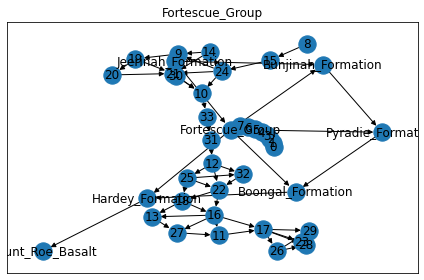

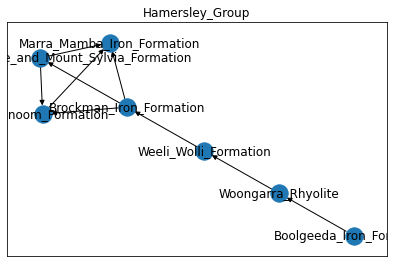

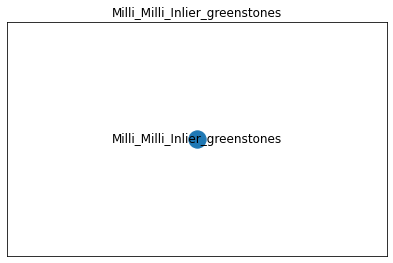

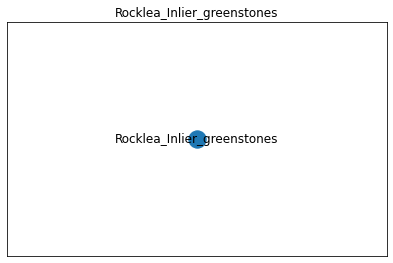

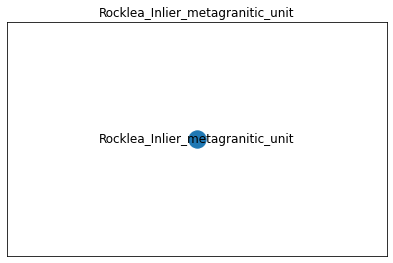

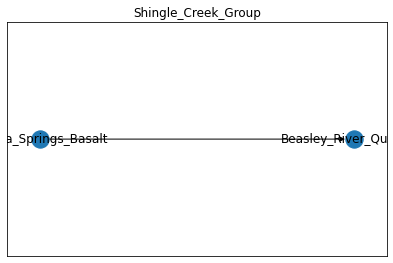

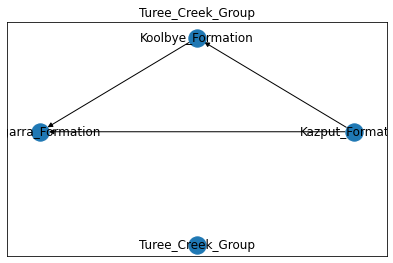

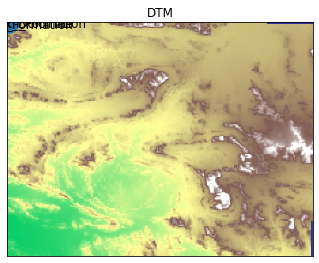

 30%|███       | 30/100 [00:06<00:11,  6.25it/s]

group choices: 3
dtb and dtb_null set to 0
245 orientations saved to ./test/output/orientations.csv


 50%|█████     | 50/100 [00:07<00:04, 10.56it/s]

extra orientations saved as /empty_series_orientations.csv
basal contacts saved allpts =  6017 deci_pts =  1570
saved as ./test/tmp/all_contacts.csv and ./test/tmp/contacts.csv
basal contacts without faults saved as ./test/tmp/basal_contacts.shp


 50%|█████     | 50/100 [00:20<00:04, 10.56it/s]

decimated contacts saved as ./test/output/contacts4.csv


 60%|██████    | 60/100 [00:21<00:19,  2.02it/s]

All observations n= 256
groups ['Hamersley Group' 'Fortescue Group' 'Turee Creek Group'
 'Shingle Creek Group' 'Wyloo Group' 'Rocklea Inlier greenstones'
 'Rocklea Inlier metagranitic unit' 'Milli Milli Inlier greenstones'] 
codes ['Wittenoom Formation' 'Mount McRae Shale and Mount Sylvia Formation'
 'Marra Mamba Iron Formation' 'Fortescue Group' 'Koolbye Formation'
 'Pyradie Formation' 'Weeli Wolli Formation' 'Boolgeeda Iron Formation'
 'Jeerinah Formation' 'Hardey Formation' 'Boongal Formation'
 'Kungarra Formation' 'Kazput Formation' 'Beasley River Quartzite'
 'Cheela Springs Basalt' 'Mount McGrath Formation' 'Ashburton Formation'
 'Woongarra Rhyolite' 'Turee Creek Group' 'Bunjinah Formation'
 'Brockman Iron Formation' 'Rocklea Inlier greenstones' 'Mount Roe Basalt'
 'Rocklea Inlier metagranitic unit' 'Milli Milli Inlier greenstones'
 'Duck Creek Dolomite']


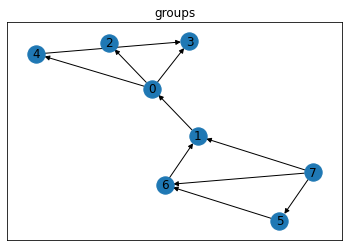

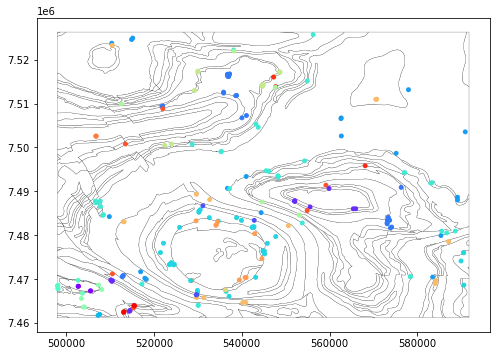

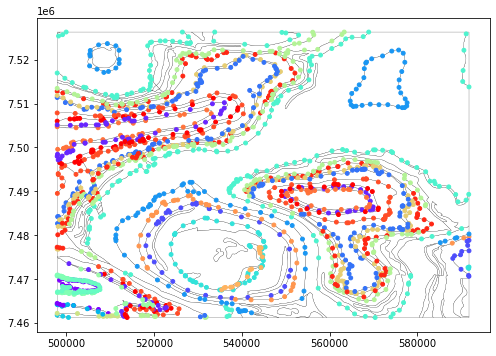

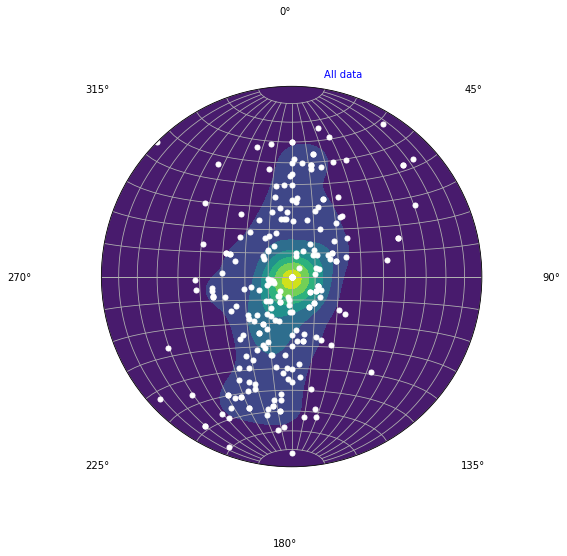

----------------------------------------------------------------------------------------------------------------------
Hamersley Group observations n= 89
strike/dip of girdle 202.8610609950826 / 89.69573401641429


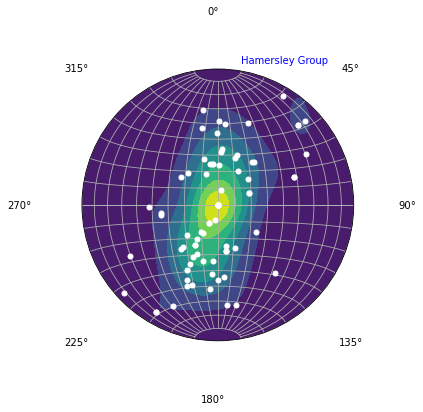

----------------------------------------------------------------------------------------------------------------------
Fortescue Group observations n= 136
strike/dip of girdle 193.92804143033447 / 87.29148737355573


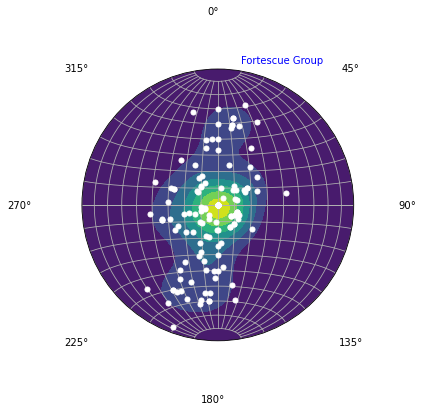

----------------------------------------------------------------------------------------------------------------------
Turee Creek Group observations n= 13
strike/dip of girdle 7.092159270474724 / 87.85289865340684


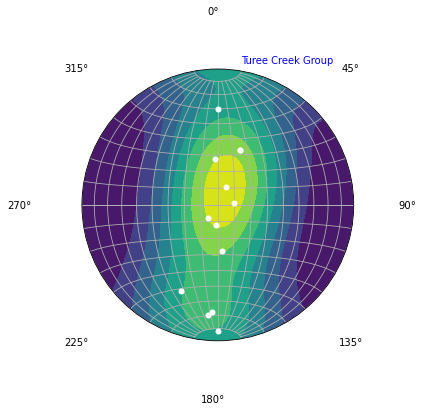

----------------------------------------------------------------------------------------------------------------------
Shingle Creek Group observations n= 6
strike/dip of girdle 179.0841356916913 / 87.09563919081386


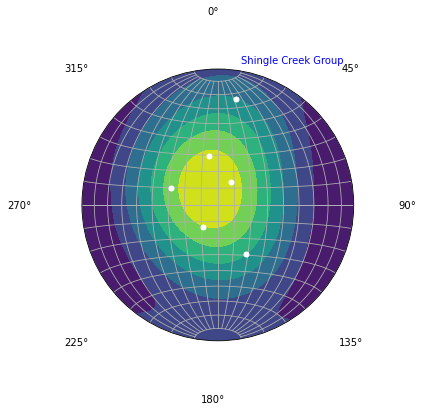

----------------------------------------------------------------------------------------------------------------------
Wyloo Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
Rocklea Inlier greenstones observations n= 10
strike/dip of girdle 166.91551753117363 / 66.09480097860053


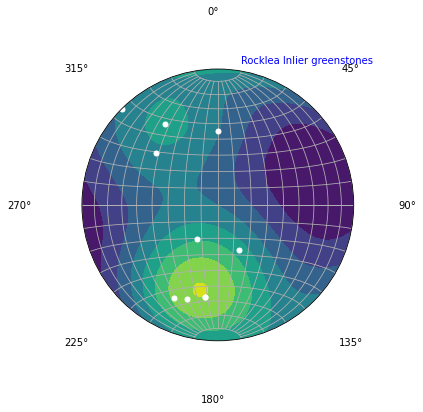

----------------------------------------------------------------------------------------------------------------------
Rocklea Inlier metagranitic unit observations n= 2
strike/dip of girdle 162.50000000000003 / 68.5312835366866


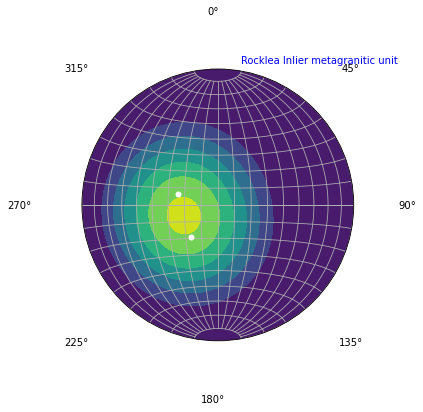

----------------------------------------------------------------------------------------------------------------------
Milli Milli Inlier greenstones observations has no observations
rbf_split 0 24629
['Fortescue Group', 'Hamersley Group', 'Turee Creek Group', 'Rocklea Inlier greenstones', 'Shingle Creek Group', 'Rocklea Inlier metagranitic unit', 'Wyloo Group', 'Milli Milli Inlier greenstones']
188 131
interpolated dips


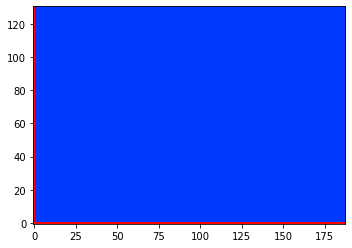

interpolated dip directions


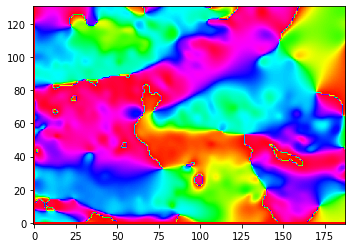

interpolated contacts


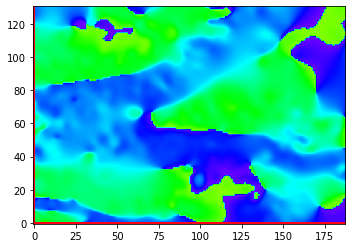

 70%|███████   | 70/100 [00:38<00:24,  1.20it/s]

fault orientations saved as ./test/output/fault_orientations.csv
fault positions saved as ./test/output/faults.csv
fault dimensions saved as ./test/output/fault_dimensions.csv
Fault Fault_7344 with displacement of 14953 capped to 3669.263483961296
Fault Fault_7344 with displacement of 8952 capped to 3669.263483961296
Fault Fault_8551 with displacement of 1193 capped to 924.7458453030276
Fault Fault_14303 with displacement of 624 capped to 158.35562960928675
Fault Fault_962 with displacement of 1051 capped to 175.35348393442075
Fault Fault_6000 with displacement of 279 capped to 247.56096017634678
Fault Fault_12641 with displacement of 737 capped to 554.8770274173733
Fault Fault_12641 with displacement of 772 capped to 554.8770274173733
Fault Fault_14251 with displacement of 415 capped to 323.1698581002754
Fault Fault_16399 with displacement of 221 capped to 159.74206544813703
Fault Fault_16754 with displacement of 533 capped to 502.06351303533654
Fault Fault_16769 with displacement of 

 90%|█████████ | 90/100 [02:26<00:29,  2.91s/it]

0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 Rocklea_Inlier_metagranitic_unit
6 Rocklea_Inlier_greenstones
7 Milli_Milli_Inlier_greenstones
pluton contacts and orientations saved as:
./test/output/ign_contacts.csv
./test/output/ign_orientations_domes.csv
Propagating dips along contacts...
154
1124 points saved to ./test/tmp/raw_contacts.csv
680 thickness estimates saved as ./test/output/formation_thicknesses.csv
['Jeerinah_Formation' 'Mount_McRae_Shale_and_Mount_Sylvia_Formation'
 'Wittenoom_Formation' 'Marra_Mamba_Iron_Formation' 'Hardey_Formation'
 'Weeli_Wolli_Formation' 'Woongarra_Rhyolite' 'Mount_Roe_Basalt'
 'Pyradie_Formation' 'Boolgeeda_Iron_Formation' 'Koolbye_Formation'
 'Beasley_River_Quartzite' 'Brockman_Iron_Formation' 'Boongal_Formation'
 'Mount_McGrath_Formation' 'Cheela_Springs_Basalt' 'Kungarra_Formation'] already processed
266 min thickness estimates appended to ./test/output/formation_thicknesses.csv
Jeerinah_Formation

100%|██████████| 100/100 [03:22<00:00,  2.02s/it]

cycles [['Fault_313', 'Fault_2837', 'Fault_16825', 'Fault_7966'], ['Fault_958', 'Fault_16503', 'Fault_813']]


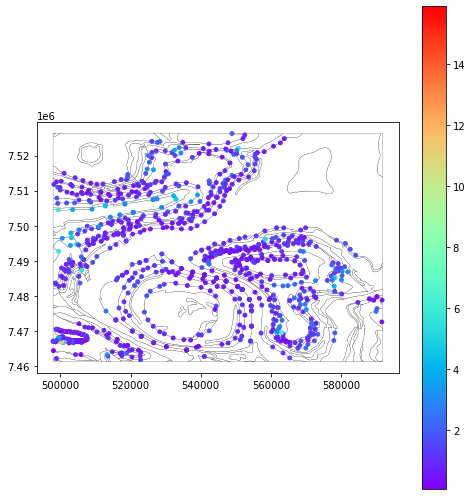

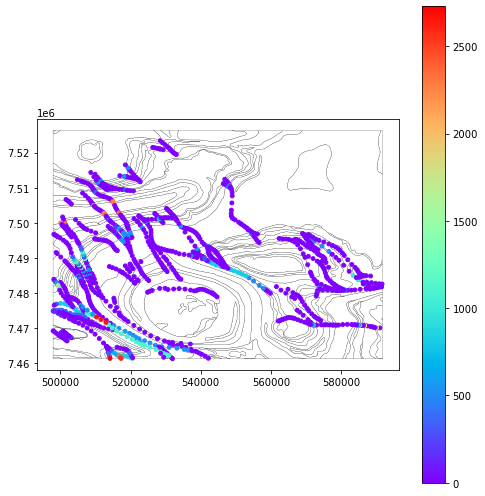

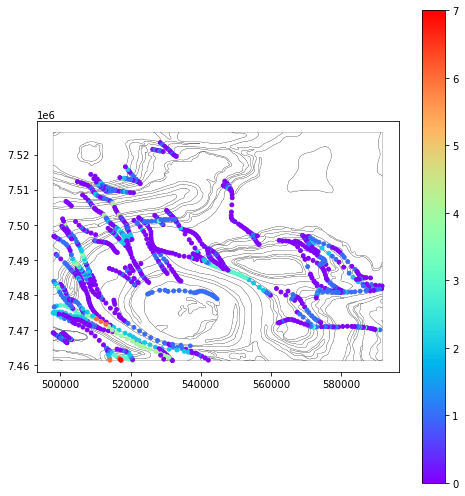

In [8]:
proj.run()

# Converting map2loop output to LoopStructural input
The map2loop process produces the following outputs that are useful for 3D geological modelling:
* structural data constraining the orientation of stratigraphic units and foliations
* contact location for geological units 
* location of fault traces
* geometry of fault plane
* estimate of fault displacement
* thickness of formations
* stratigraphic offset across faults
* stratigraphic relationships (order of stratigraphic units)
* fault - fault relationships (order of overprinting of faults)

Text(0.5, 1.0, 'Fault network graph')

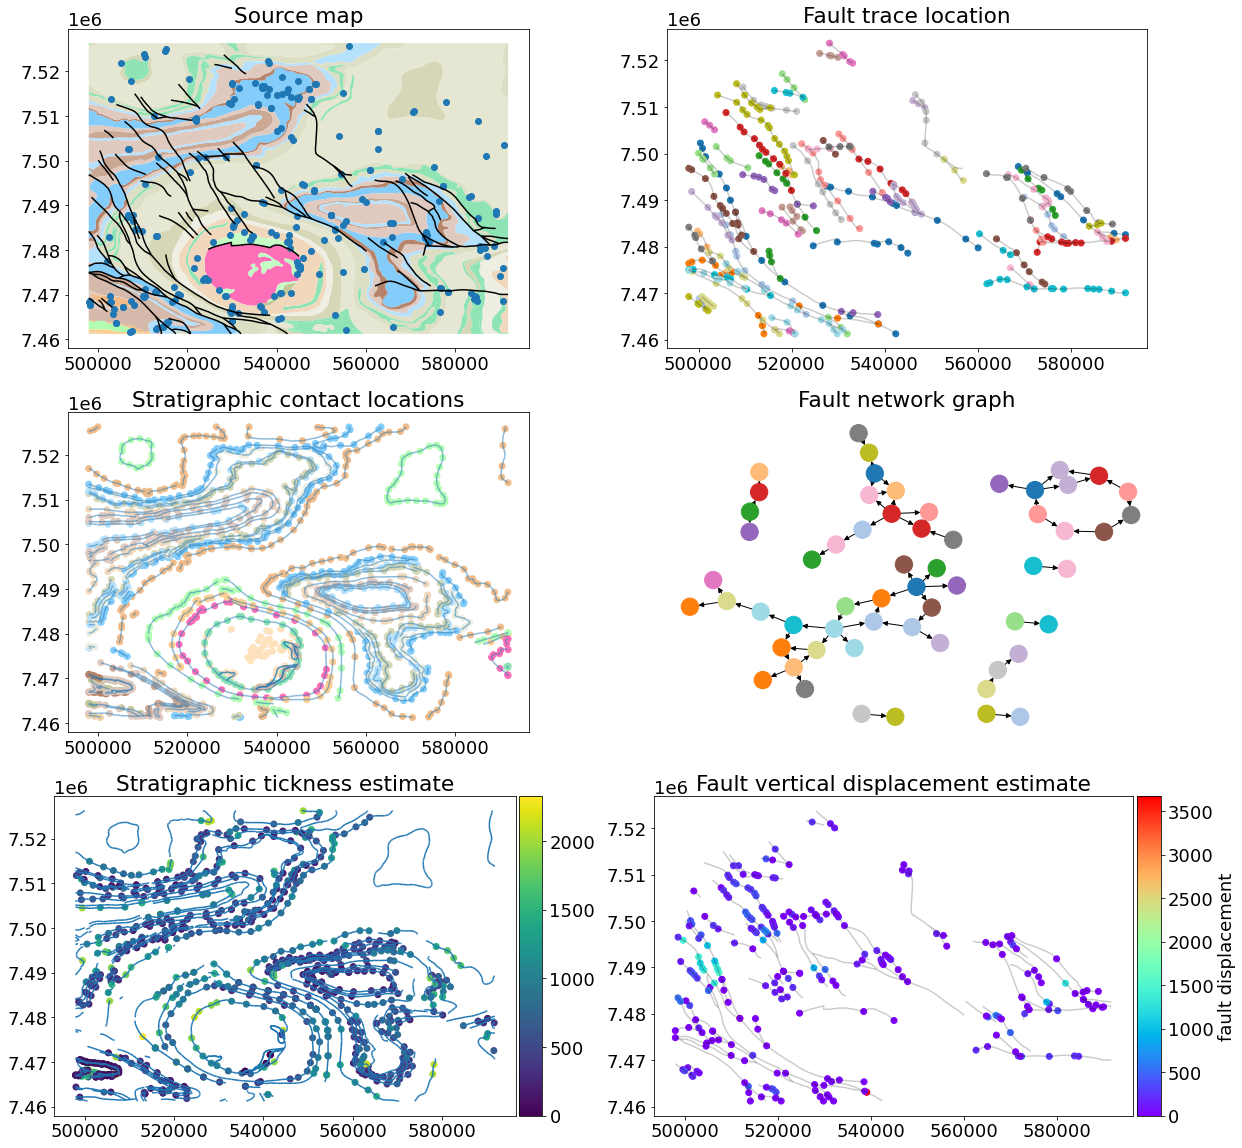

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from networkx.algorithms.components import weakly_connected_components
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
plt.rcParams.update({'font.size': 18})
#  matplotlib import rcParams
# rcParams['fontsize']=22
fig, ax = plt.subplots(3,2,figsize=(20,20))
proj.config.geol_clip.plot(ax=ax[0,0], column=proj.config.c_l['c'],cmap=proj.config.cmap)
proj.config.structure_clip.plot(ax=ax[0,0])
proj.config.faults_clip.plot(ax=ax[0,0],color='black')
proj.config.faults_clip.plot(ax=ax[0,1],color='black',alpha=0.2)
proj.config.faults_clip.plot(ax=ax[2,1],color='black',alpha=0.2)

basal_contacts = geopandas.read_file(proj.config.tmp_path+'/basal_contacts.shp')
# geology.plot(,
#                                 figsize=(10, 10),
#                                 ax=ax,
#                                 edgecolor='#000000',
#                                 linewidth=0.2,
#                                 legend=True,
#                                 cmap=self.cmap)
ax[0,0].set_title('Source map')
basal_contacts.plot(ax=ax[1,0],alpha=0.5)
basal_contacts.plot(ax=ax[2,0])

contacts = pd.read_csv(proj.config.output_path+'/contacts_clean.csv')
strat_id, code = pd.factorize(contacts['formation'])

faults = pd.read_csv(proj.config.output_path+'/faults.csv')
fault_id, fault_code = pd.factorize(faults['formation'])
thickness = pd.read_csv(proj.config.output_path+'/formation_thicknesses.csv')
fault_displacements = pd.read_csv(proj.config.output_path+'/fault_displacements3.csv')
ax[1,0].scatter(contacts['X'],contacts['Y'],c=strat_id,cmap=proj.config.cmap)
ax[0,1].scatter(faults['X'],faults['Y'],c=fault_id,cmap='tab20')
thick_colormap = ax[2,0].scatter(thickness['X'],thickness['Y'],c=thickness['thickness'])
divider=make_axes_locatable(ax[2,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(thick_colormap, cax=cax1)
# fig.colorbar(,ax=ax[2,0])
displacement_colormap = ax[2,1].scatter(fault_displacements['X'],fault_displacements['Y'],c=fault_displacements['vertical_displacement'],cmap='rainbow')
divider = make_axes_locatable(ax[2,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(displacement_colormap,cax=cax2,label='fault displacement')
fault_displacements['vx'] = np.sin(np.deg2rad(fault_displacements['downthrow_dir']))
fault_displacements['vy'] = np.cos(np.deg2rad(fault_displacements['downthrow_dir']))

# ax[0,2].quiver(fault_displacements['X'],fault_displacements['Y'],fault_displacements['vx'],fault_displacements['vy'])
# proj.config.faults_clip.
# ax[0,2].plot()

ax[0,1].set_title('Fault trace location')
ax[2,1].set_title('Fault vertical displacement estimate')
ax[1,0].set_title('Stratigraphic contact locations')
ax[2,0].set_title('Stratigraphic tickness estimate')


G = nx.read_gml(proj.config.tmp_path+'/fault_network.gml')
colours = np.arange(len(fault_code))
nodes = [n for n in fault_code]
node_colours = {nodes[i]: colours[i] for i in range(len(colours))}
pos=nx.nx_agraph.graphviz_layout(G,prog="neato")
colours = np.arange(len(G.nodes))
for h in weakly_connected_components(G):
    sub = G.subgraph(h)
    colours = [node_colours[n] for n in sub.nodes]
    nx.draw(sub,pos,node_color=colours,vmin=0,vmax=len(nodes)-1,cmap='tab20',ax=ax[1,1])
ax[1,1].set_title('Fault network graph')

## Processing faults
LoopStructural represents faults using a fault frame where three scalar fields are modelled:
1. Fault surface
2. Fault slip direction
3. Fault extent

The fault surface is interpolated using the fault 
The fault surface ccanb eThis can All of the faults are extracted from the model and map2loop extracts the vertices from the polyline. The vertices are then used by LoopStructural to define the loremoves all of the faults below a cutoff threshold

In [14]:
# proj.config.faults_clip.plot()
# fault_trace = pd.read_csv(proj.config.output_path+'/faults.csv')
# fault_orinetations = pd.read_csv(proj.config.output_path+'/fault_orientations.csv')
# fault_displacement = pd.read_csv(proj.config.)
# plt.scatter(fault_trace['X'],fault_trace['Y'])

In [15]:
import pandas as pd
contacts_clean = pd.read_csv(proj.config.output_path+'/contacts_clean.csv',index_col='index')
orientations = pd.read_csv(proj.config.output_path+'/contact_orientations.csv')
thicknesses = pd.read_csv(proj.config.output_path+'/formation_summary_thicknesses.csv')
stratigraphic_order = pd.read_csv(proj.config.tmp_path+'/all_sorts.csv',index_col='index')

## Building the stratigraphic dataset

* `contacts_clean` is a table that contains the location and name of the basal contact for a stratigraphic horizon. 
* `stratigraphic_order` is a table that contains the relative stratigraphic column for the map
* `thicknesses` is a table containing the summary of the thicknesses of each stratigraphic unit.
* `orientations` is a table containing the location and strike/dip of a structural observation.

To build an implicit model this dataset needs to be converted into input for LoopStructural. We need to define which geological units are conformable, which will define which units can be represented using different isosurfaces of the same scalar field. To do this we identify a reference horizon and define the relative distance from this reference horizon to every contact by accumulating the thickness of the units. This will define the value of the implicit function that is being interpolated. 

To build this dataset we use the `stratigraphic_order` table which characterises the local stratigraphy for the map by identifying which groups the stratigraphic units are in and the relative location of each stratigraphic unit in the group.  
Where there are multiple groups on the map it is possible to determine whether different groups are conformable. Another file `supergroups.csv` provides this information, each line in this file defines the members of a supergroups. 

When modelling areas with sparse datasets (e.g. primarily from mapsheets) it is often preferable to as many geological interfaces into the same implicit function. This is because the orientation observations, and the geometry of different horizons will help to constrain the other units that may not be as well constrained in the outcrop. 

LoopStructural automatically calculates the value of the implicit function for each stratigraphic unit using the stratigraphic order and the estimated unit thickness from map2loop. The orientation observations constrain the geometry of the geological surface at a particular location. LoopStructural converts the dip and dip direction into a normal vector observation. 

In [16]:
orientations

,X,Y,Z,azimuth,dip,polarity,formation
0,518417.475403,7.494639e+06,522.242291,305.605254,24.942743,1,Jeerinah_Formation
1,516011.179835,7.494796e+06,562.753454,312.332717,24.941626,1,Jeerinah_Formation
2,514659.774908,7.494188e+06,572.592975,308.596969,24.941745,1,Jeerinah_Formation
3,512321.495607,7.492540e+06,615.991638,334.993760,24.941619,1,Jeerinah_Formation
4,510577.065983,7.491477e+06,549.233990,320.154320,24.941475,1,Jeerinah_Formation
...,...,...,...,...,...,...,...
1019,509948.098494,7.496202e+06,617.487966,337.401645,24.938291,1,Mount_McRae_Shale_and_Mount_Sylvia_Formation
1020,507733.128423,7.495210e+06,600.402343,324.469961,24.937574,1,Mount_McRae_Shale_and_Mount_Sylvia_Formation
1021,507537.309287,7.494231e+06,596.318894,328.255242,24.938242,1,Wittenoom_Formation
1022,510642.019241,7.495251e+06,574.432935,150.603764,24.938906,1,Wittenoom_Formation


## Loop Structural

In [17]:
# Define project bounds
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']


In [19]:
# checking files are consistent for loopstructural
if(not os.path.exists(proj.config.fault_file_csv)):
    f=open(output_path + '/fault_displacements3.csv','w')
    f.write('X,Y,fname,apparent_displacement,vertical_displacement,downthrow_dir\n')
    f.close()
    f=open(proj.config.output_path + '/fault_orientations.csv','w')
    f.write('X,Y,Z,DipDirection,dip,DipPolarity,formation\n')
    f.close()
    f=open(proj.config.output_path + '/faults.csv','w')
    f.write('X,Y,Z,formation\n')
    f.close()
    f=open(proj.config.output_path + '/fault-fault-relationships.csv','w')
    f.write('fault_id\n')
    f.close()
    f=open(proj.config.output_path + '/group-fault-relationships.csv','w')
    f.write('group\n')
    f.close()
#defining a bounding box
f=open(proj.config.tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

In [20]:

fault_params = {'interpolatortype':'FDI',
                'nelements':1e5,
                'step':10,
                'fault_buffer':0.1,
                'solver':'pyamg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':1e5,  # how many tetras/voxels
                    'buffer':0.8,  # how much to extend nterpolation around box
                    'solver':'pyamg',
                    'damp':True}


model, m2l_data = GeologicalModel.from_map2loop_directory(proj.config.project_path,
                                                              evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
                                                          foliation_params=foliation_params)


In [57]:
model.update()

  0%|          | 0/220 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pyamg/krylov/_cg.py:155: UserWarning: 
Indefinite preconditioner detected in CG, aborting

  warn("\nIndefinite preconditioner detected in CG, aborting\n")
/opt/conda/lib/python3.7/site-packages/pyamg/krylov/_cg.py:155: UserWarning: 
Indefinite preconditioner detected in CG, aborting

  warn("\nIndefinite preconditioner detected in CG, aborting\n")


In [59]:
view = LavaVuModelViewer(model)
view.add_model_surfaces()
# view.add_data(model['supergroup_0'])
view.interactive()

  0%|          | 0/96 [00:00<?, ?it/s]

2021-04-16 08:45:33,672 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Cannot isosurface Fault_14303 at 0, skipping
2021-04-16 08:45:33,672 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Cannot isosurface Fault_14303 at 0, skipping
2021-04-16 08:45:33,672 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Cannot isosurface Fault_14303 at 0, skipping


No surface found at the given iso value.


2021-04-16 08:45:33,902 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:33,902 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:33,902 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:39,688 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:39,688 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:39,688 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:41,291 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-16 08:45:41,291 ~ LoopStructural.visualisation.model_visualis

Adding surfaces took 14.145439147949219 seconds
